<a href="https://colab.research.google.com/github/Jaseelkt007/Signal_processing/blob/main/JPEG_compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## JPEG Compression basics
 JPEG uses a change of basis idea to compress images, and specifically it uses the Discrete Cosine Transform (DCT) to achieve this


 1. Image Preparation
Load a high-resolution RGB image (e.g., 1920×1080).

Convert the RGB to YCbCr color space because human eyes are less sensitive to chroma.

Focus initially on just the Y channel (luminance), for simplicity.

2. Divide into 8×8 Patches
Divide the image into non-overlapping 8×8 blocks (on the Y channel first).

Each 8×8 patch becomes a matrix of pixel intensities.

3. Apply DCT
For each 8×8 block, apply the 2D DCT.

This transforms the spatial domain into the frequency domain.

Low frequencies are concentrated in the top-left corner.

4. Quantization
Apply quantization using a quantization matrix (more aggressive on higher frequencies).

This step reduces many coefficients to zero.

5. Compression
Flatten each block in a zig-zag order (low to high frequency).

Encode using something like run-length encoding (RLE) or Huffman coding.

You now have JPEG-style compression

(1280, 1920)


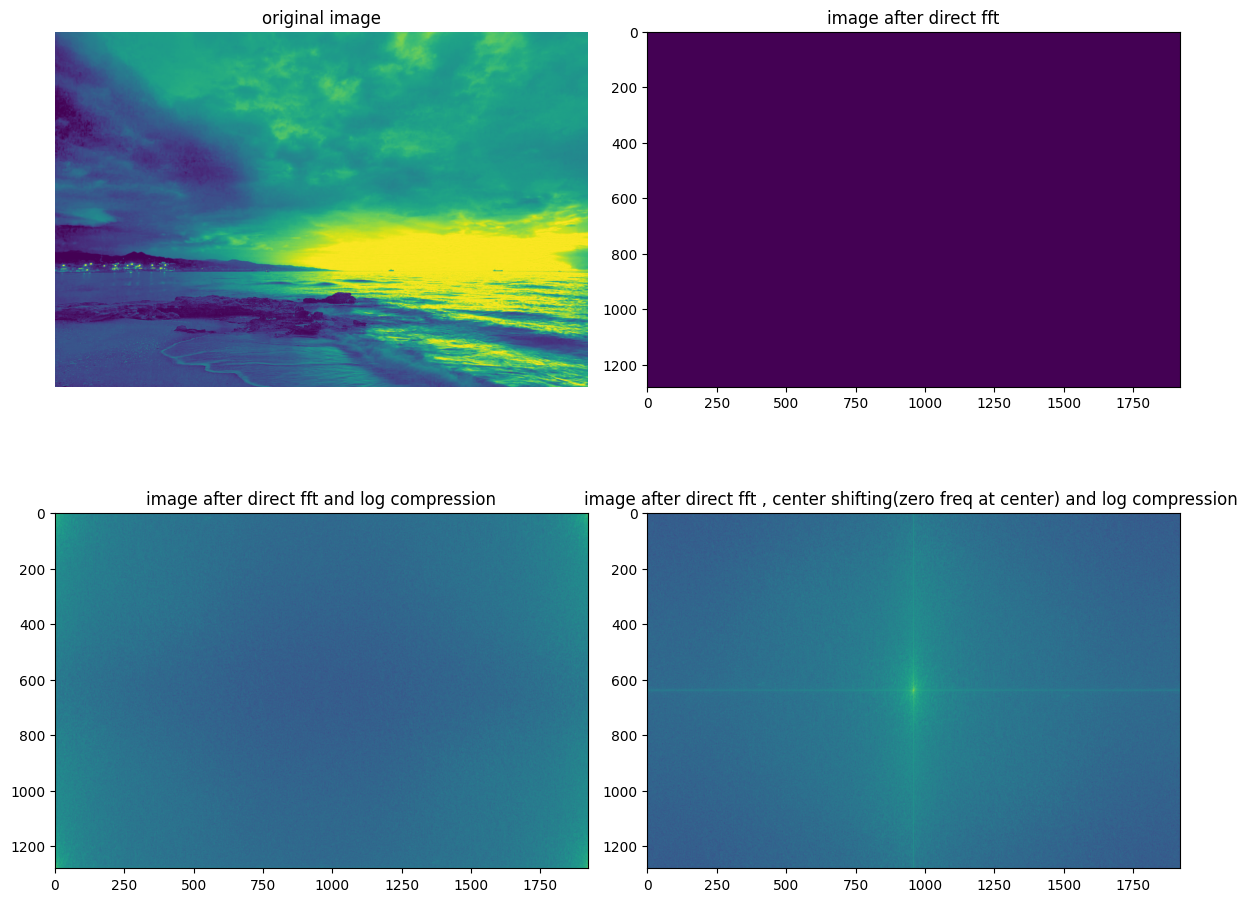

max value in log is  19.93919689178718


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

image = Image.open('image_comp.jpg').convert('RGB')
image= np.array(image)

R , G , B = image[:,:,0], image[: ,:,1], image[:,:,2]
print(R.shape)


coefficents = np.fft.fft2(B)
log_coefficents = np.log1p(np.abs(coefficents)) # apply to compress the high dynamic range of fft

# When FFT is applied, the low frequency or zero frequency components are placed at the top left corner of the result and frequency increase towards the edges
'''
+ve Rotating counter clock wise
F = [ 0, +x, -0, -x]  Top right : High freq x, low y
    [+y, +xy, -y, -xy]
    [-0, -x, -0, -x]
    [-y, -xy, +y, +xy]

np.abs(F) --> remove the phase(angle) info, ie, positive = negative frequency, thats why in visualization , it looks symmetric
'''
# But for visualization purpose we move zero frequency component to center of the spectrum and high frequency radiate from the center to create more intuitive visualization

coefficents_shifted = np.fft.fftshift(coefficents) # Center the zero frequency
log_coef_shifted = np.log1p(np.abs(coefficents_shifted))

plt.figure(figsize=(12,10))
plt.subplot(2,2,1) # 2 rows, 2 columns , 1st position -> top left
plt.title("original image")
plt.imshow(R)
plt.axis('off')

plt.subplot(2,2,2) # top right
plt.title("image after direct fft")
plt.imshow(np.abs(coefficents))

plt.subplot(2,2,3) # bottom left
plt.title("image after direct fft and log compression")
plt.imshow(log_coefficents)

plt.subplot(2,2,4) # bottom right
'''After fftshift: This is only do VISUALIZATION PURPOSE not for compression
[high freq | low freq | high freq]
[low freq  |   DC     | low freq ]
[high freq | low freq | high freq]
'''
plt.title("image after direct fft , center shifting(zero freq at center) and log compression ")
plt.imshow(log_coef_shifted)

plt.tight_layout()  # Adjusts spacing between subplots
plt.show()

# the absolute FFT coefficents have an extremely wide dynamic range
# FFT values are higher for low frequencies and low for high frequencies
print("max value in log is ", np.max(np.abs(log_coefficents)))

Now Try to reconstruct the original image:
1. P = WC , here W is the inverse Fourier basis
2. C = W.t P , Fourier transform of P to get coefficent.

1. without compression
2. with compression

[[216. 215. 214. ... 236. 236. 235.]
 [217. 215. 213. ... 238. 238. 237.]
 [217. 216. 212. ... 239. 239. 238.]
 ...
 [ 75.  92.  97. ... 132. 129. 124.]
 [122. 120. 118. ... 124. 131. 133.]
 [128. 126. 133. ... 132. 130. 124.]]


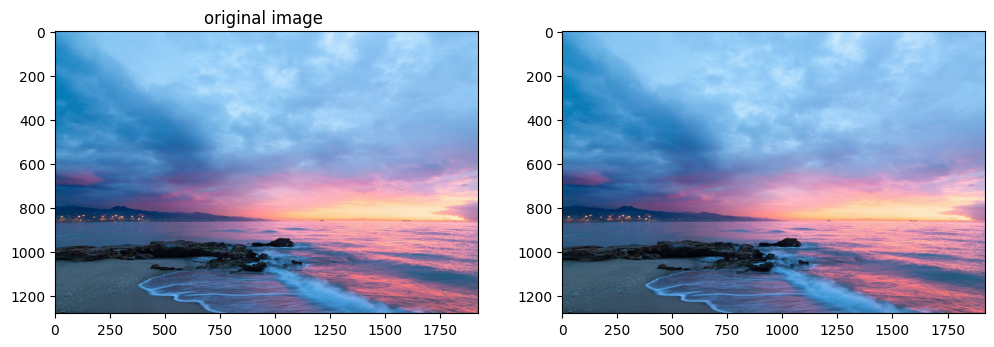

In [60]:
from PIL import Image

image_reconstructed = np.fft.ifft2(coefficents)
# the result may contain small complex parts due to finite precision . Note : FFT is not ill-conditioned — it’s a well-behaved, orthogonal basis transform (unitary)
print(image_reconstructed.real)

image = Image.open('image_comp.jpg').convert('RGB')
image= np.array(image)

R , G , B = image[:,:,0], image[: ,:,1], image[:,:,2]
coefficents_R , coefficents_G , coefficents_B = np.fft.fft2(R) ,np.fft.fft2(G) ,np.fft.fft2(B)
rec_R , rec_G, rec_B = np.fft.ifft2(coefficents_R) ,np.fft.ifft2(coefficents_G) ,np.fft.ifft2(coefficents_B)

image_rec_R = np.clip(rec_R.real,0,255).astype(np.uint8) # converted from float64 to uint8 cause many libraries like matplot, PIL expect uint8 for proper rendering
image_rec_G = np.clip(rec_G.real,0,255).astype(np.uint8)
image_rec_B = np.clip(rec_B.real,0,255).astype(np.uint8)
image_rec = np.stack([image_rec_R,image_rec_G,image_rec_B],axis=2) # (H, W, Channel)- for PIL ,matplot


# save the image for comparison
Image.fromarray(image_rec).save("reconstructed.png") # Saving it as png for Lossless saving ,will have larger file size
# 1920 *1080 *3 = 6220800 , 6220800*1 bytes (uint8) => 6220800/(1024kb*1024mb) = 5.93MB , PNG then compress this lossless way

# Save it in pure raw(Pure Binary Data) , no compression involed , so ~6MB
'''image_rec.tofile("reconstructed_raw.raw")''' # this is just a flat byte array means 1D array or a vector of size 1280*1920 each value is 8bit binary values: 1 byte per channel per pixel
'''
raw_data = np.fromfile('reconstructed_raw.raw', dtype=np.uint8)
image_r = raw_data.reshape((1280,1920,3))'''

plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("original image ")
plt.subplot(1,2,2)
plt.imshow(image_rec)



#Now lets do Threshold part after FFT
There are many ways strategies for Compression strategy : means filter out some coeficents
1. Keep only top-k % strongest frequencies
2. Keep only a central square in fftshifted

Resolution is not changed here, Quality and Sharpness and details are changed
1. Original image: 1920×1080 pixels = 2M pixels × 3 channels => FFT result: 1920×1080 complex coefficients
2. for eg: Zero out 80% of the coefficients, and Only store or transmit the remaining 20% --> After thresholding, you have a sparse matrix (mostly zeros)

still 0 is also counted to memory for eg: [0,0,255,128] -> 4 bytes, and [0,0,0,0,] -> still 4 bytes, so to reduce the size we have to some compresion algorithm techniques to represent it more efficently


In [ ]:
image = Image.open('image_comp.jpg').convert('RGB')
image= np.array(image)
R , G , B = image[:,:,0], image[: ,:,1], image[:,:,2]
coefficents_R , coefficents_G , coefficents_B = np.fft.fft2(R) ,np.fft.fft2(G) ,np.fft.fft2(B)

# 1. 80% filterout: Out of all the FFT coefficients, we’re keeping only the top 20% most energetic ones
'''
Lower Frequencies : top left of fft -> capture overall structure, smooth gradient , brightness => Higher in magnitude
Higher Frequencies : corner of fft -> capture, fine details, noise, sharp edges, => Small in magnitude

Note: Higher magnitude coefficients usually correspond to low frequencies but can also some high frequency component too
Threshold for Keeping the top 20% of coefficients by magnitude
'''

threshold_R = np.percentile(np.abs(coefficents_R),80) # compute the 80th percentile value of this 2D array = scalar value
threshold_G = np.percentile(np.abs(coefficents_G),80)
threshold_B = np.percentile(np.abs(coefficents_B),80)

mask_R = np.abs(coefficents_R) >= threshold_R # create masks for filterout to keep only the higher energetic frequencies (top 20% frequencies in magnitude, mostly low frequencies)
mask_G = np.abs(coefficents_G) >= threshold_G
mask_B = np.abs(coefficents_B) >= threshold_B



